In [1]:
validation_set_size = 25
BATCH_SIZE = 512
IMAGE_SIZE = 64
NUMBER_OF_PARTICLES = 0.2 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 14e-6
NEW_MODELS=1
pixel_size = 0.114e-6
save_model_path = "/content/drive/MyDrive/Kandidatarbete/data/oscar/"
models_path = "/content/drive/MyDrive/Kandidatarbete/data/oscar/"

In [2]:
#@title Install packages
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3
    !pip install --upgrade scipy
    !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
    !apt install texlive-science

import matplotlib
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rc
import deeptrack as dt
import tensorflow.keras as keras
import scipy.io as spio
import re
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tensorflow.keras import layers, models

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{siunitx}', r'\usepackage{lipsum}']

     |████████████████████████████████| 80 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 12.7 MB/s 
     |████████████████████████████████| 462 kB 44.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-acc

In [3]:
"""Importing the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

# Load a matfile with "downsized" ROI:s around particles found in the experimental data 
# Download mat-file from shared drive to your private one if to run in Colab!]

def load_all_data_to_dict(filenames):
  filenames = sorted([filename for filename in filenames if (".mat" in filename)])
  paths_with_zero = [file for file in filenames if re.search('.*0.mat', file)]
  paths_without_zero = [file for file in filenames if not re.search('.*0.mat', file) and re.search('.*.mat', file)]

  p1 = [re.sub('0.mat', '', path_with_zero) for path_with_zero in paths_with_zero]
  p2 = [re.sub('.mat', '', path_without_zero) for path_without_zero in paths_without_zero]
  one_part_sets = list(set(p2).difference(p1))
  two_part_sets = list(set(p1).intersection(p2))

  data = {}

  for file_name in one_part_sets:
    traces = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = traces

  for file_name in two_part_sets:
    first_part = spio.loadmat(data_path + file_name + '0.mat', simplify_cells=True)['CompletedTraces']
    second_part = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = np.concatenate((first_part, second_part))

  return data

def load_0wt_data_to_dict(filenames):
  filenames = sorted([filename for filename in filenames if bool(re.search('^0wt.*wGold.*.mat$', filename))])
  paths_with_zero = [file for file in filenames if re.search('.*0.mat', file)]
  paths_without_zero = [file for file in filenames if not re.search('.*0.mat', file) and re.search('.*.mat', file)]

  p1 = [re.sub('0.mat', '', path_with_zero) for path_with_zero in paths_with_zero]
  p2 = [re.sub('.mat', '', path_without_zero) for path_without_zero in paths_without_zero]
  one_part_sets = list(set(p2).difference(p1))
  two_part_sets = list(set(p1).intersection(p2))

  data = {}

  for file_name in one_part_sets:
    traces = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = traces

  for file_name in two_part_sets:
    first_part = spio.loadmat(data_path + file_name + '0.mat', simplify_cells=True)['CompletedTraces']
    second_part = spio.loadmat(data_path + file_name + '.mat', simplify_cells=True)['CompletedTraces']
    name = re.search('^[0-9]{,3}', file_name).group() + 'pct' + re.search('_.{,2}Gold', file_name).group()
    data[name] = np.concatenate((first_part, second_part))

  return data

drive.mount('/content/drive')
data_path = './drive/MyDrive/Kandidatarbete/data/erik/'
filenames = !ls $data_path

data_dict = load_0wt_data_to_dict(filenames)

Mounted at /content/drive


In [4]:
import random
shortest_trace = 50

ROIdata = {}
for key in data_dict.keys():
  data = data_dict[key]
  shape = [64, 64]

  traces = []
  # This loop unpacks and stores all fields found in the processed video in a 3d-array
  for trace in data:
    roi_data = trace['ROI']
    seriesROI = []

    if roi_data.shape[0] <= shortest_trace:
      continue
    for j in range(roi_data.shape[0]):
      particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
      particleROI = np.fft.fftshift(particleROI)
      particleROI = np.expand_dims(particleROI, axis = -1)
      if "wGold" in key:
        particleROI = particleROI*0.25*np.exp(-0.61j)
      seriesROI.append(particleROI)
    traces.append(np.array(seriesROI))
  ROIdata[key] = traces


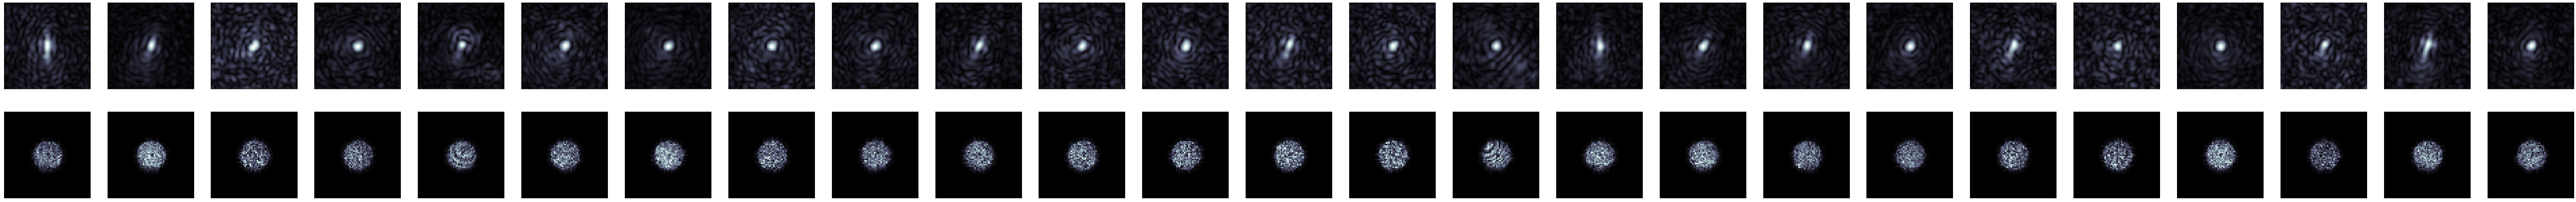

In [5]:
validation_set_size = min(validation_set_size, len(ROIdata["0pct_wGold"]))
validation_set = []
for trace in random.sample(ROIdata["0pct_wGold"], validation_set_size):
  validation_set.append(trace[np.random.randint(0, shortest_trace),...])

fig, ax = plt.subplots(2, validation_set_size, figsize=(validation_set_size*5, 10))
for i, img in enumerate(validation_set):
  ax[0, i].imshow(np.abs(img[..., 0]), cmap='bone')
  ax[0, i].set_xticks([])
  ax[0, i].set_yticks([])
  ax[1, i].imshow(np.abs(np.fft.fftshift(np.fft.fft2(img[..., 0]))), cmap='bone')
  ax[1, i].set_xticks([])
  ax[1, i].set_yticks([])


We currently get the following structure:

Dictionary with a value for each file's key \
-List of all traces in file longer than _shortest_trace_ \
--Numpy array of with structure [image number in trace, x, y, dud]

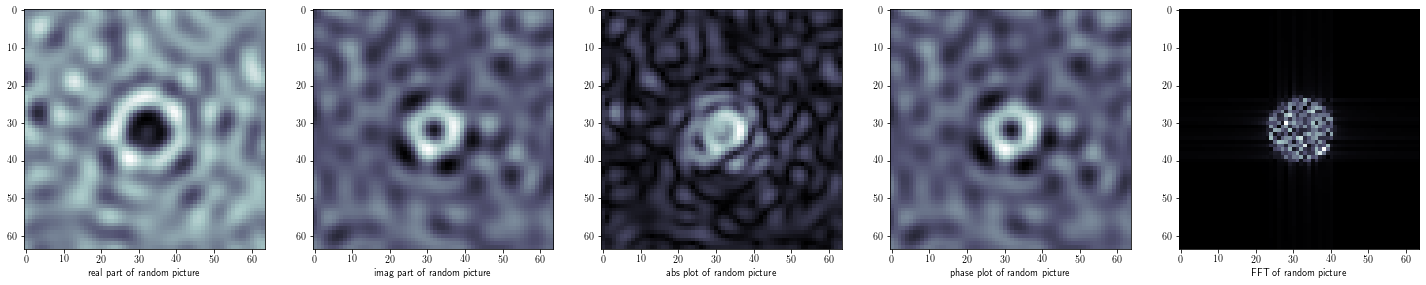

In [6]:
particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: np.random.randn() * (Z_RANGE/pixel_size)//2,
    radius=lambda: 150e-9 + 5e-9 * np.random.rand() , #1.5e-7 + 1e-7 * np.random.rand() ,
    refractive_index=lambda: 1.46 + np.random.uniform(0, 0.03),#np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

particle_middle2 = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: np.random.randn() * (Z_RANGE/pixel_size)//2, #np.random.uniform(-2,2),
    radius=lambda: 150e-9 + 5e-9 * np.random.rand() , #1.5e-7 + 1e-7 * np.random.rand() ,
    refractive_index=lambda: 1.46 + np.random.uniform(0, 0.03),#np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)
CROP = dt.Lambda(crop, pupil_radius=lambda: 26) #IMAGE_SIZE//6

optics = dt.Brightfield(
    NA=1.3, #1.3*1.55,
    resolution=1.13e-6,
    wavelength=525e-9,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC+CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.02 + np.random.rand() * 0.01,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.02j + np.random.rand() * 0.01j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)

def normalization_func():
    def inner(image):
        return image - np.mean(np.real(image))
    return inner

normalization = dt.Lambda(normalization_func)

"""Plotting one random image and creating the dataset"""
def particles(particle):
    return particle ** 0 # max(0, round(np.random.poisson(lam=NUMBER_OF_PARTICLES)))

dataset = optics(particle_middle + noise + gradient) + normalization
dataset_no_augmentation = dataset
dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))

validation_dataset = optics(particle_middle + noise + gradient) + normalization

simulated_validation_set = [validation_dataset.update().resolve() for _ in range(validation_set_size)]


test_image = validation_dataset.update().resolve()[:,:,0]

fig, ax = plt.subplots(1, 5, figsize=(25,5))
ax[0].imshow(np.real(test_image), cmap='bone')
ax[0].set_xlabel("real part of random picture")
ax[1].imshow(np.imag(test_image), cmap='bone')
ax[1].set_xlabel("imag part of random picture")
ax[2].imshow(np.abs(test_image), cmap='bone')
ax[2].set_xlabel("abs plot of random picture")
ax[3].imshow(np.angle(test_image+1), cmap='bone')
ax[3].set_xlabel("phase plot of random picture")
ax[4].imshow(np.abs(np.fft.fftshift(np.fft.fft2(test_image))), cmap='bone')
ax[4].set_xlabel("FFT of random picture")
plt.show()

1.0
0.9999999999999999
0.14010314971385995
simulated


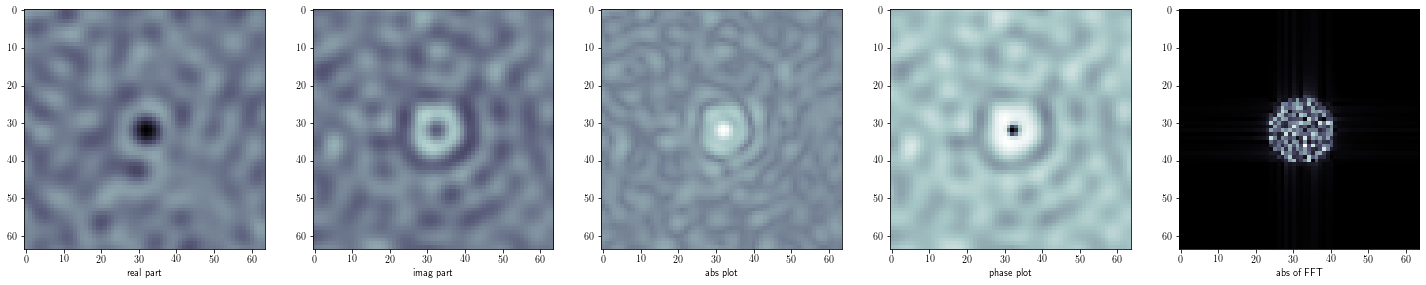

validation


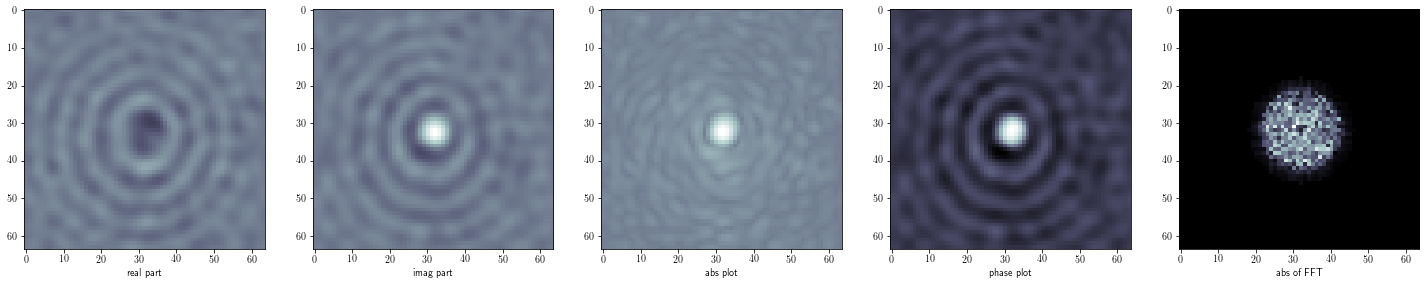

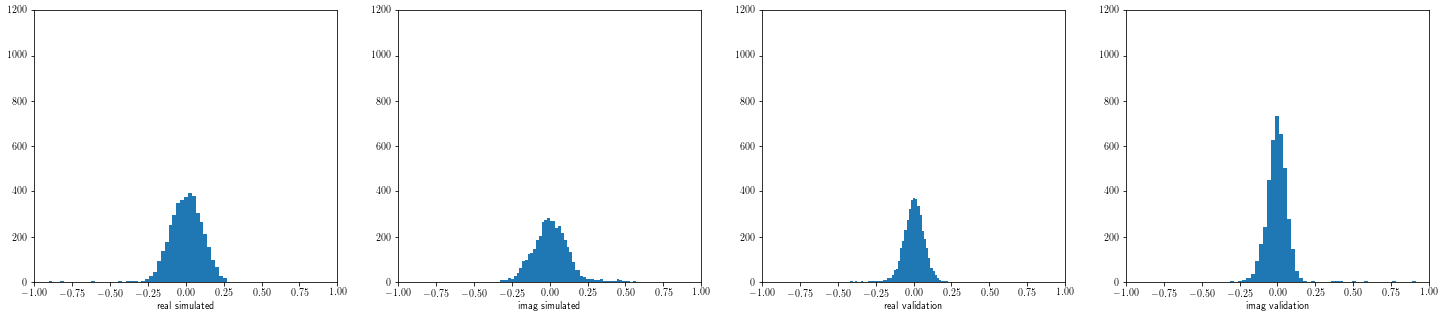

In [7]:
#@title Plot simulated and experimental images to compare
"""Plotting simulated data"""
def plot_all(image):
    fig, ax = plt.subplots(1, 5, figsize=(25,5))
    ax[0].imshow(np.real(image), cmap='bone', vmin=vmin, vmax=vmax)
    ax[0].set_xlabel("real part")
    ax[1].imshow(np.imag(image), cmap='bone', vmin=vmin, vmax=vmax)
    ax[1].set_xlabel("imag part")
    ax[2].imshow(np.abs(image), cmap='bone', vmin=vmin, vmax=vmax)
    ax[2].set_xlabel("abs plot")
    ax[3].imshow(np.angle(image+1), cmap='bone')
    ax[3].set_xlabel("phase plot")
    ax[4].imshow(np.abs(np.fft.fftshift(np.fft.fft2(image))), cmap='bone')
    ax[4].set_xlabel("abs of FFT")
    plt.show()

def hist_of_images(validation_image, simulated_image):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))
    ax1.hist(np.real(simulated_image).flatten(), bins = np.linspace(np.min(np.real(simulated_image)), np.max(np.real(simulated_image)), 50))
    ax1.set_xlabel("real simulated")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, 1200])
    ax2.hist(np.imag(simulated_image).flatten(), bins = np.linspace(np.min(np.imag(simulated_image)), np.max(np.imag(simulated_image)), 50))
    ax2.set_xlabel("imag simulated")
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([0, 1200])
    ax3.hist(np.real(validation_image).flatten(), bins = np.linspace(np.min(np.real(validation_image)), np.max(np.real(validation_image)), 50))
    ax3.set_xlabel("real validation")
    ax3.set_xlim([-1, 1])
    ax3.set_ylim([0, 1200])
    ax4.hist(np.imag(validation_image).flatten(), bins = np.linspace(np.min(np.imag(validation_image)), np.max(np.imag(validation_image)), 50))
    ax4.set_xlabel("imag validation")
    ax4.set_xlim([-1, 1])
    ax4.set_ylim([0, 1200])
    plt.show()

validation_image = random.choice(validation_set)[...,0]
validation_image = validation_image / np.max(np.abs(validation_image))
simulated_image = dataset_no_augmentation.update().resolve()[:,:,0]
#simulated_image -= np.mean(simulated_image)
simulated_image = simulated_image / np.max(np.abs(simulated_image))

print(np.max(np.abs(validation_image)))
print(np.max(np.abs(simulated_image)))
print(np.mean(np.abs(simulated_image)))

vmin = np.min([
    np.min(np.real(validation_image)),
    np.min(np.imag(validation_image)),
    np.min(np.real(simulated_image)),
    np.min(np.imag(simulated_image))]
)
vmax = np.max([
    np.max(np.real(validation_image)),
    np.max(np.imag(validation_image)),
    np.max(np.real(simulated_image)),
    np.max(np.imag(simulated_image))]
)
bins = (-0.2, 0.2, 300)
binz = (0.8, 1.2, 300)

print("simulated")
plot_all(simulated_image)
print("validation")
plot_all(validation_image)
hist_of_images(validation_image, simulated_image)

In [8]:
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    if padding>0:
      return im[padding:-padding, padding:-padding]
    else:
      return im

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z, prop_matrices, padding):
    """Re-propagate the images using PAS"""
    crop_propagation_forward, crop_propagation_backward = prop_matrices
    ft_image = fourier_transform(image[..., 0], padding=padding)
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_forward, crop_propagation_backward, z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image, padding=padding), axis=-1)

In [9]:
def create_validation_stack(images, z_list, prop_matrices, padding):
    output = []
    for i in range(images.shape[0]):
        image = images[i, ...]
        stack = []
        for z in z_list:
          stack.append(propagate(image, z, prop_matrices, padding))
        output.append(stack)
    return np.array(output)

def evaluate_model(model, val_stack, prop_range):
  all_predictions=[]
  for i in range(min(val_stack.shape[0], 150)):
    predictions = []
    for image in val_stack[i, ...]:
      image = np.expand_dims(image, axis=0)
      z_pred = model.predict(image[..., 0])[0,0]
      predictions.append(z_pred)
    all_predictions.append(np.array(predictions)-np.mean(np.array(predictions))) #-zref
  all_predictions = -np.array(all_predictions)

  fig, axs = plt.subplots(1,2, figsize=(16,6))
  
  lines = []
  for i in range(all_predictions.shape[0]):
      lines.append(axs[0].plot(prop_range*1e-1, all_predictions[i,:], alpha=0.5))
      axs[0].set_title("Numeriskt ompropagerade bilder", fontsize=20)
      axs[0].set_xlabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
      axs[0].set_ylabel(r"Predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
      axs[0].set_xticks(np.linspace(prop_range[0]*1e-1, prop_range[-1]*1e-1, 9))
      axs[0].set_yticks(np.linspace(prop_range[0]*1e-1-2, prop_range[-1]*1e-1+2, 11))

      #lower = np.round(min(np.min(all_predictions), -8))
      #upper = np.ceil(max(np.max(all_predictions)+1, 9))
      # axs[0].set_yticks(np.arange(lower, upper, 1))
      axs[0].grid(True)



  line, = axs[0].plot(prop_range*1e-1, prop_range*1e-1, '--k', alpha=1, linewidth=2)
  ln = plt.Line2D((0,1),(0,0), color='k')
  axs[0].legend([line, ln], ["Korrekt prediktion", "Prediktion på individuella partiklar"], fontsize=12)
  axs[0].tick_params(labelsize=16)
  fig.suptitle('Validering av CNN tränat på simulerad data', fontsize=24)

  # plt.yticks(fontsize=16)
  # plt.xticks(fontsize=16)
  
  for i in range(all_predictions.shape[-1]):
      axs[1].scatter((prop_range)[i]*1e-1, np.std(all_predictions[:,i]), c="r", marker=".", alpha=0.95)
      axs[1].set_title("Standardavvikelse för numeriskt ompropagerade bilder", fontsize=20)
      axs[1].set_ylabel(r"Standardavvikelse i predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
      axs[1].set_xlabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
      axs[1].set_xticks(np.linspace(prop_range[0]*1e-1, prop_range[-1]*1e-1, 9))
      axs[1].set_ylim(0, 2)
      plt.yticks(fontsize=16)
      plt.xticks(fontsize=16)
      axs[1].grid(True)
  plt.show()

wavelength = 525e-9
padding = 0
size = (IMAGE_SIZE + padding,)*2
crop_propagation_forward = get_propagation_matrix(size, 1e-7, pixel_size, wavelength)
crop_propagation_backward = get_propagation_matrix(size, -1e-7, pixel_size, wavelength)
prop_matrices = (crop_propagation_forward, crop_propagation_backward)

z_list = np.linspace(-80, 80, 50)
prop_range=z_list
val_stack = create_validation_stack(np.array(validation_set), z_list, prop_matrices, padding)
sim_val_stack = create_validation_stack(np.array(simulated_validation_set), z_list, prop_matrices, padding)

In [ ]:
evaluate_model(model, val_stack, prop_range)
#plt.savefig("./experimental_data", bbox_inches='tight')
#evaluate_model(model, sim_val_stack, prop_range)
#plt.savefig("./simulated_data", bbox_inches='tight')

NameError: ignored

In [10]:
#@title define get_label function
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""
def get_label(image):
    return np.array([image.get_property("z")*pixel_size*1e6])

In [11]:
from tensorflow.math import abs, angle, real, imag, subtract

class CustomLayer(keras.layers.Layer):
    "Takes a complex image as input and outputs 4 real images."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        norm_image = subtract(image, 1)
        return tf.squeeze(tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1), axis=-2)

"Skapar modeller!"
if True:
    if NEW_MODELS:
        models_to_train = []
        for _ in range(1):
            model = models.Sequential()
            model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
            model.add(CustomLayer())
            model.add(layers.Conv2D(16, 7, activation='relu', strides=(3,3)))
            model.add(layers.Conv2D(32, 7, activation='relu', strides=(3,3)))
            model.add(layers.Flatten())
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dense(1))
            model.compile(optimizer='adam', loss='mae')
            model.totalhistory = {"val_loss":[], "loss":[]}
            model.specs="small"
            model.summary()
            models_to_train.append(model)
    else:
        models_to_train = load_models(models_path, 3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_layer (CustomLayer)  (None, 64, 64, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 16)        3152      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          25120     
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                25632     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53,937
Trainable params: 53,937
Non-traina

In [12]:
#@title Helper functions for plotting
cc = (cycler(color=list('bgrcmyk')))

"""Helper functions to visualize progress during training."""
def save_progress(h, validation_set, validation_stack, simulated_validation_stack, prop_range, model):
    model.totalhistory["loss"].extend(h.history["loss"])     

    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    ax.plot(model.totalhistory["loss"], 'b', label="training loss")
    ax.set_xlabel("Epoch")
    ax.set_yscale('log')
    ax.legend()
    
    evaluate_model(model, validation_stack, prop_range)
    evaluate_model(model, simulated_validation_stack, prop_range)
    
    plt.show()

def plot_together(models):
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(moving_average(model.totalhistory["loss"], min(100, len(model.totalhistory["loss"])//4)), label=f"{model.specs}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Training loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Generating 2616 / 2560 samples before starting training


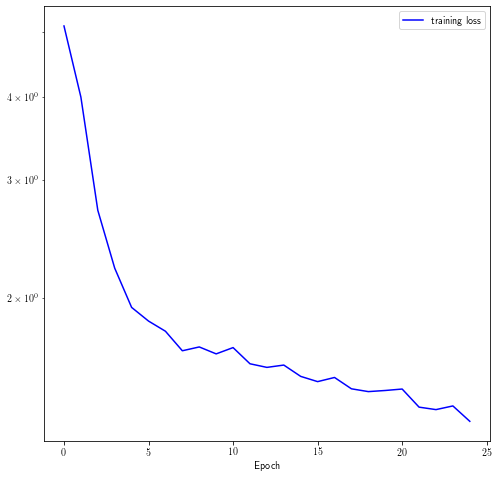

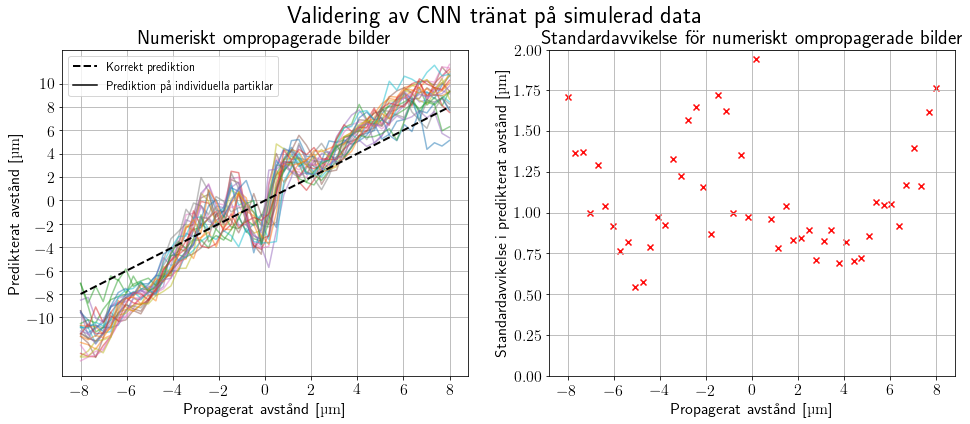

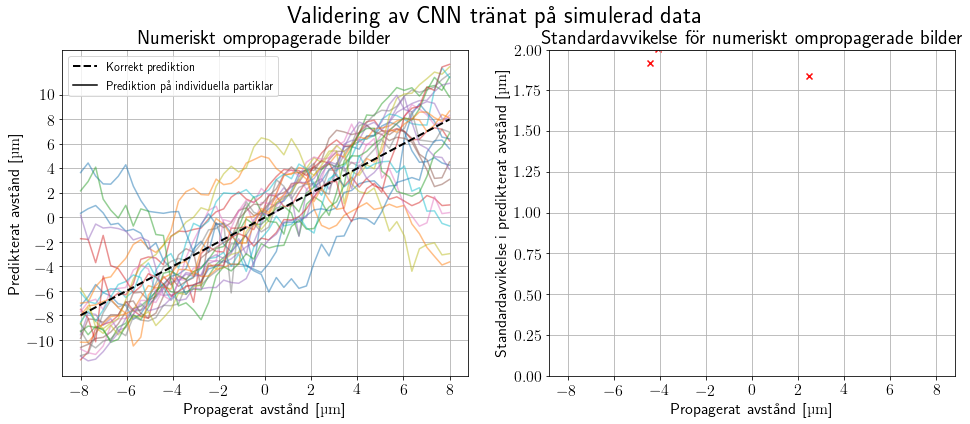

Generating 5120 / 2560 samples before starting training


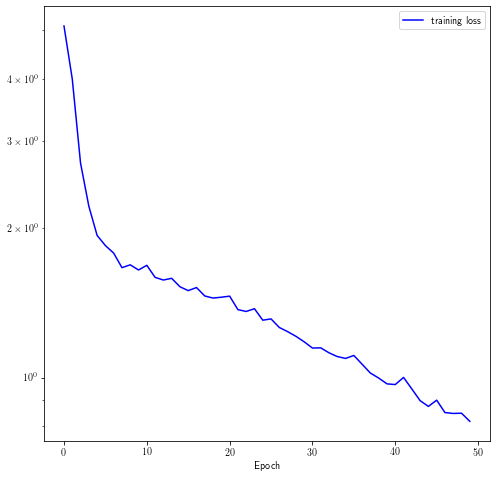

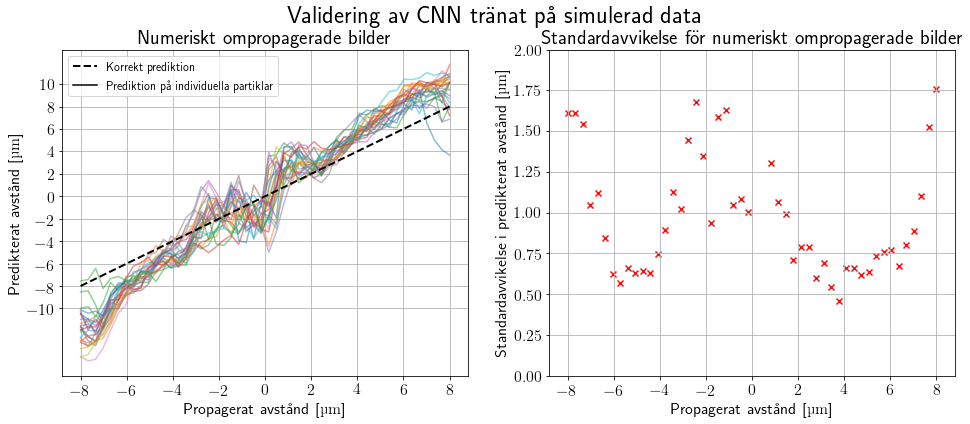

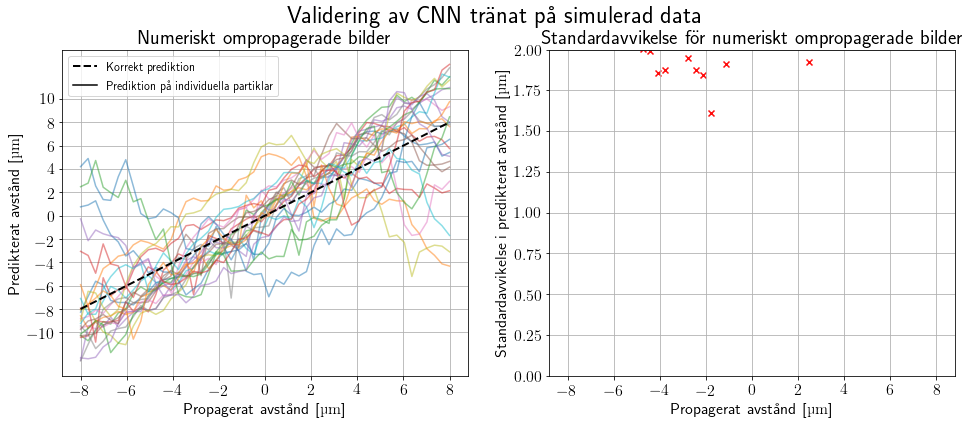

Generating 5120 / 2560 samples before starting training


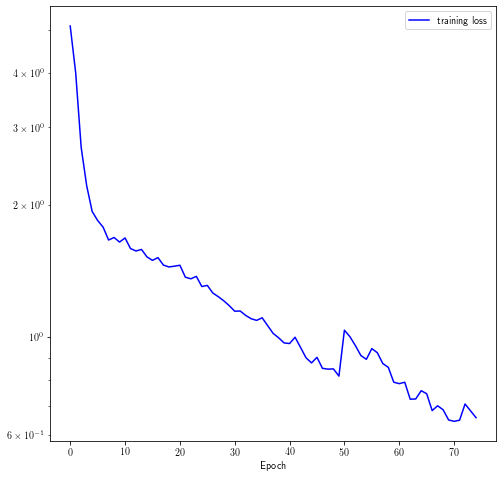

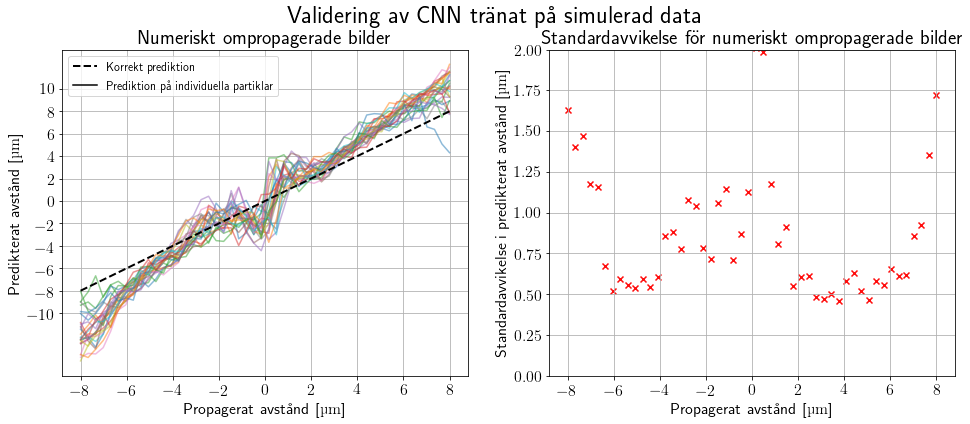

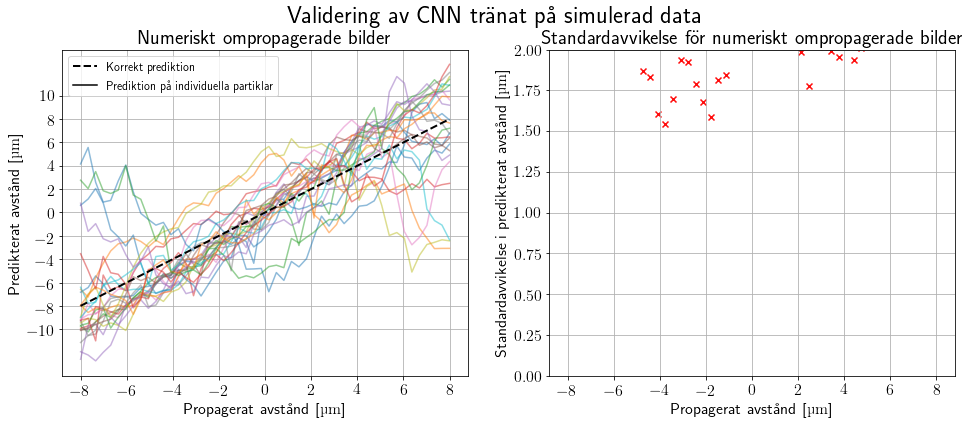

Generating 5120 / 2560 samples before starting training


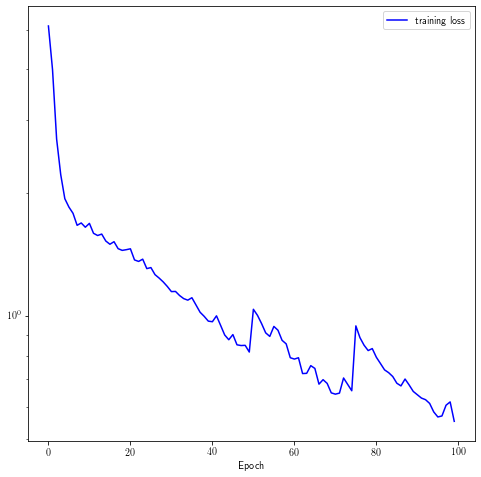

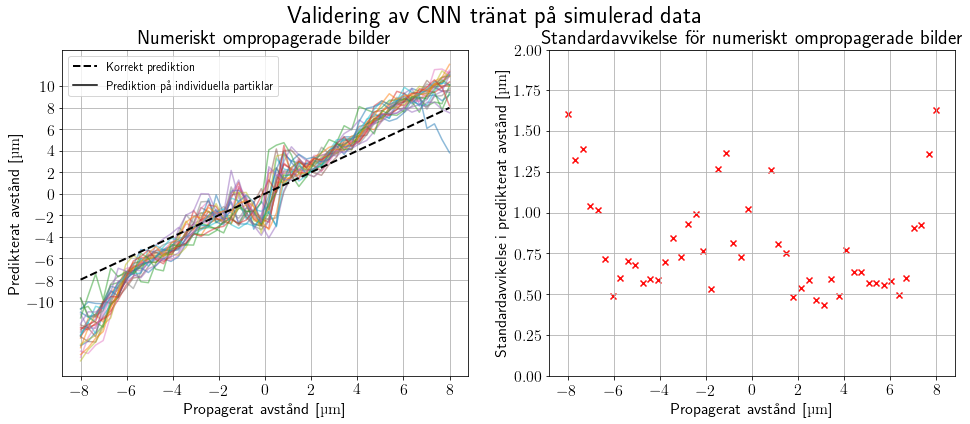

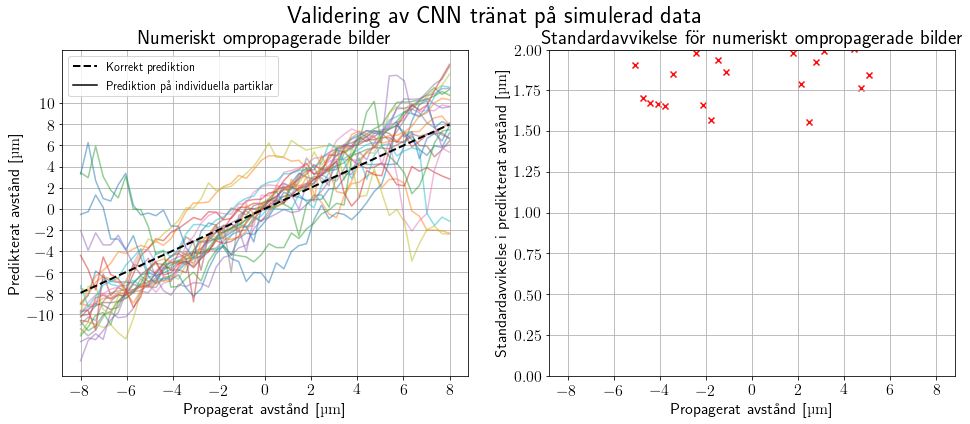

Generating 5120 / 2560 samples before starting training


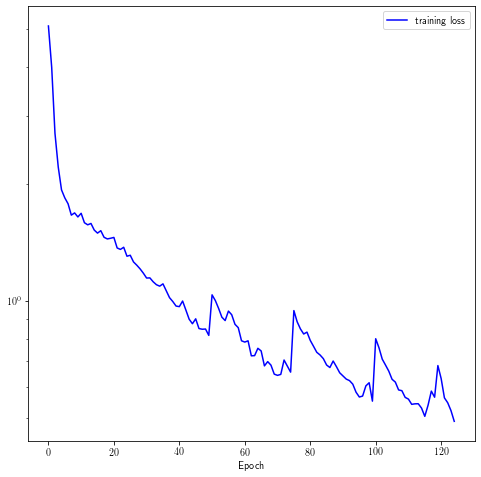

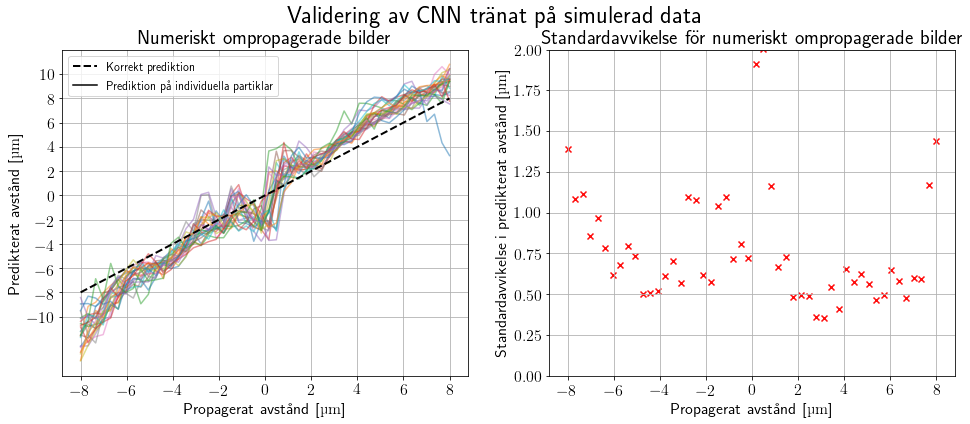

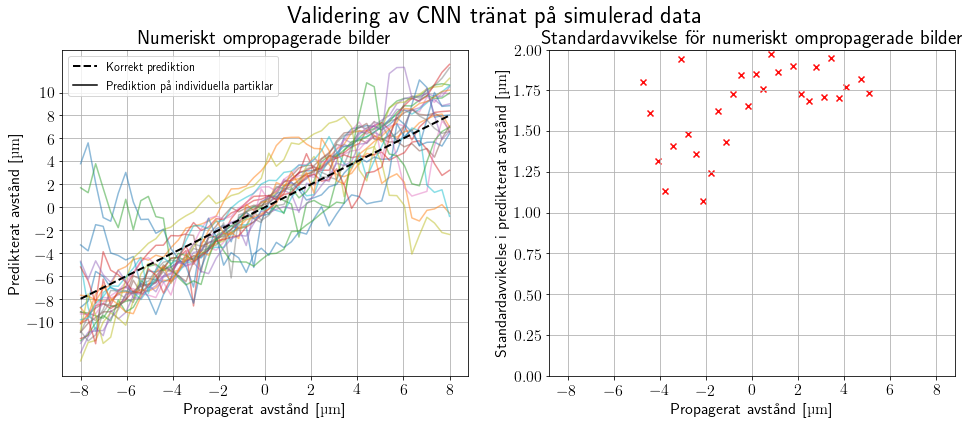

Generating 5120 / 2560 samples before starting training


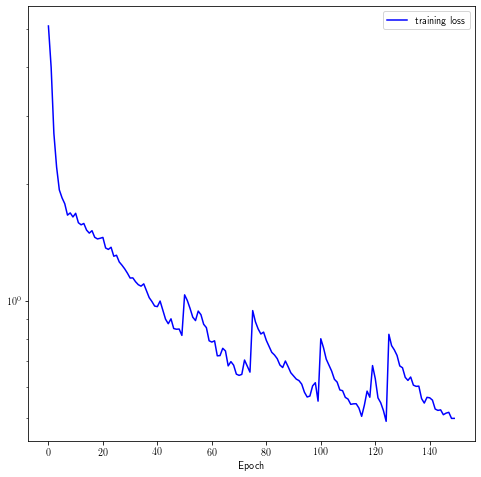

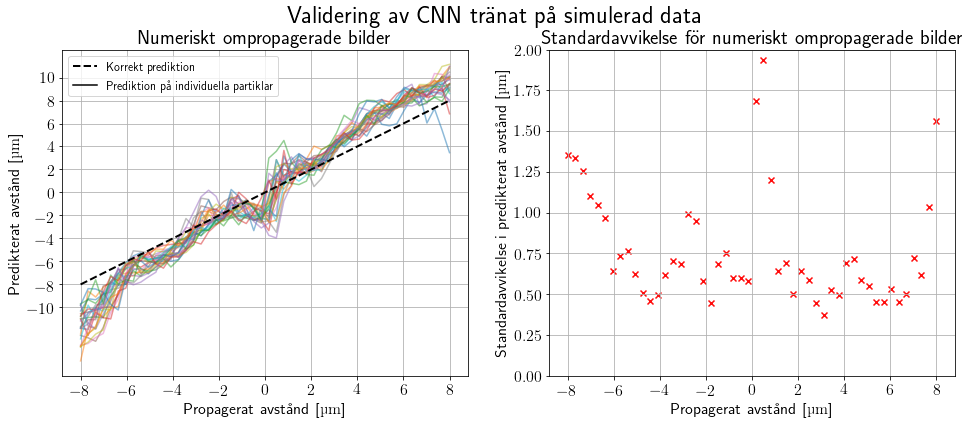

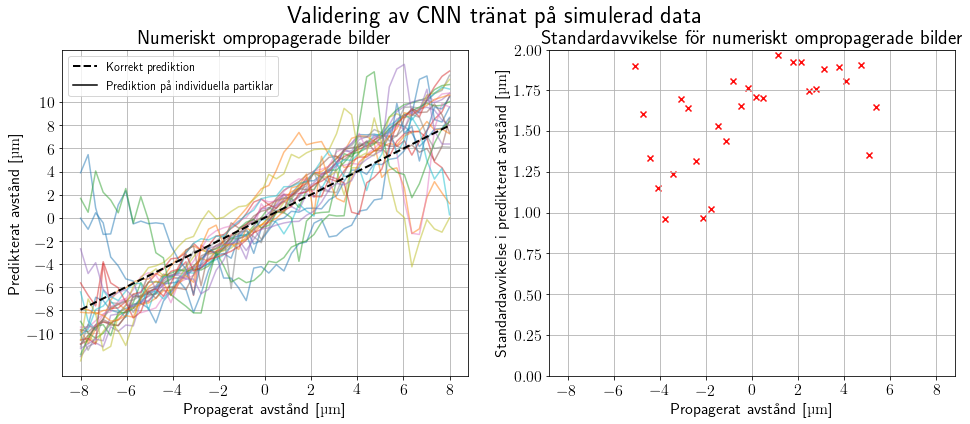

Generating 5120 / 2560 samples before starting training


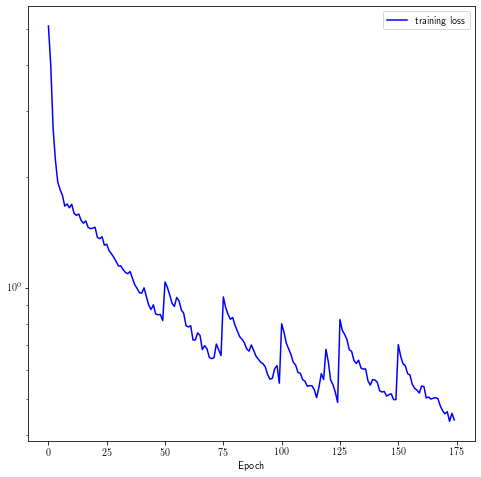

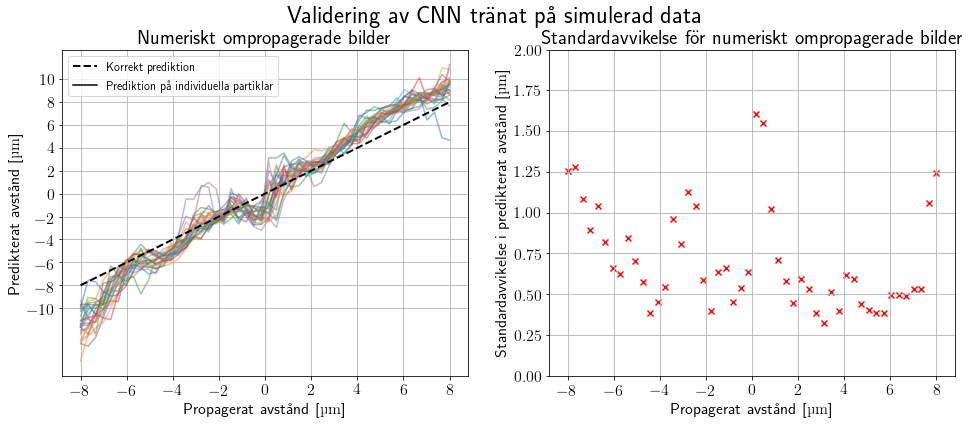

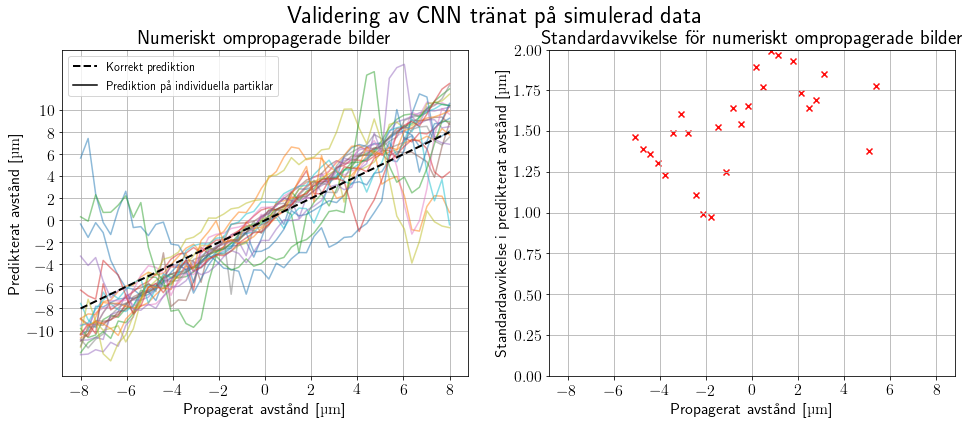

Generating 5120 / 2560 samples before starting training


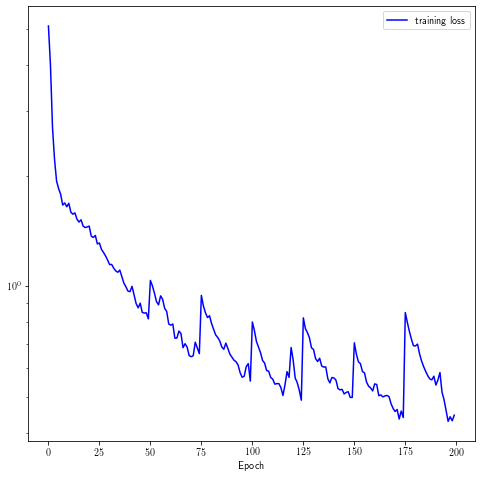

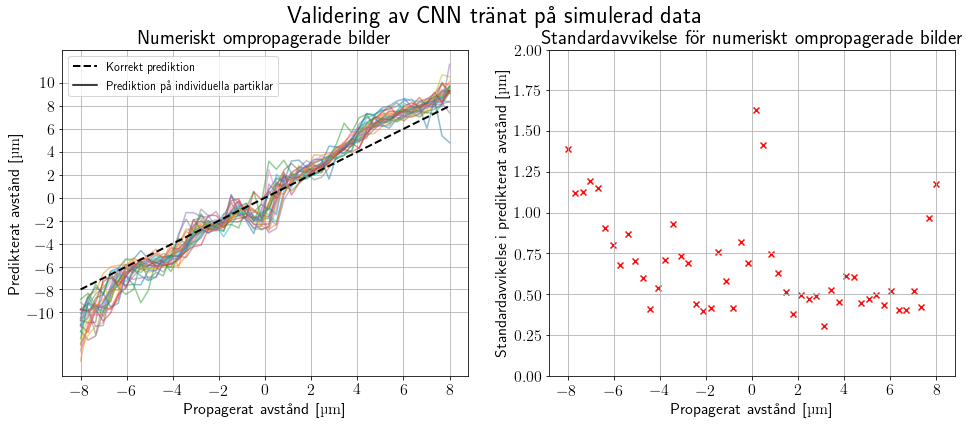

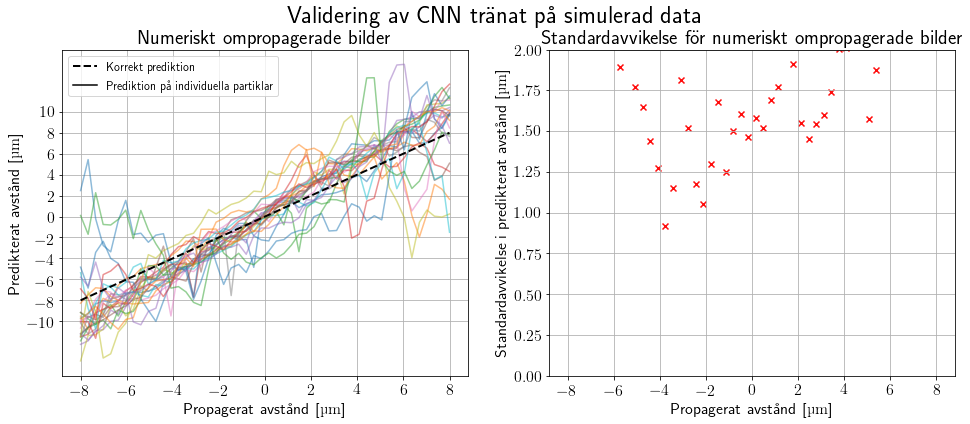

Generating 5120 / 2560 samples before starting training


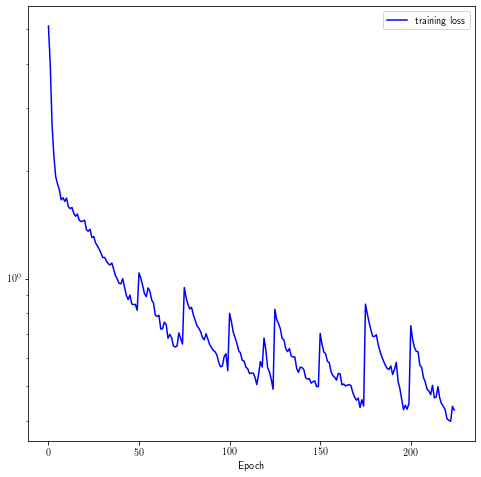

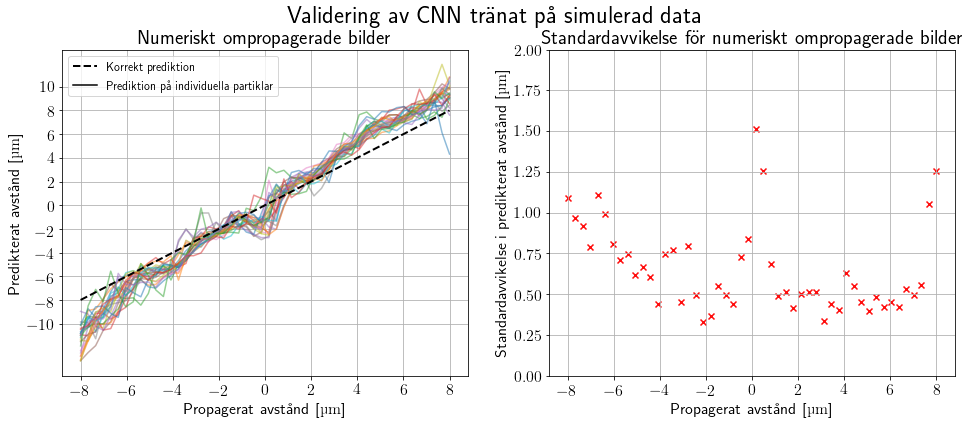

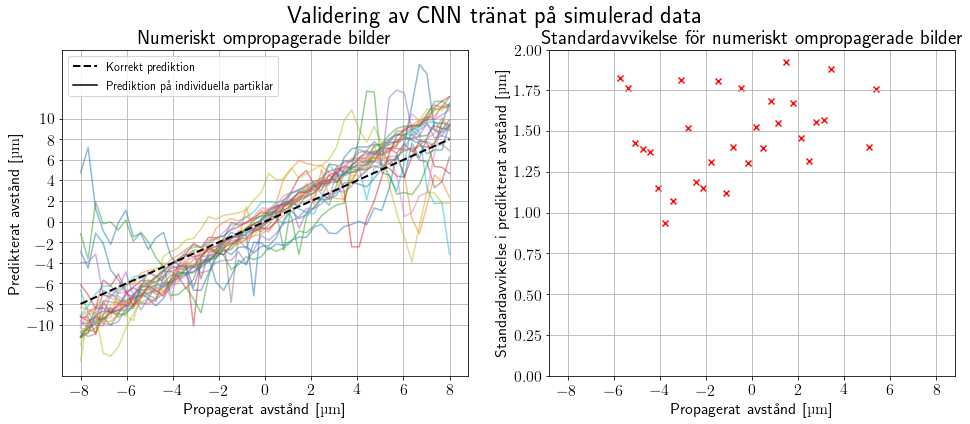

Generating 5120 / 2560 samples before starting training


In [ ]:
"""Training all the models"""
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=BATCH_SIZE*5,
    max_data_size=BATCH_SIZE*10,
    batch_size=BATCH_SIZE,
)

for _ in range(150):
    with generator:
        for i, model in enumerate(models_to_train):
            h = model.fit(generator, epochs=25, verbose=0,)
            save_progress(h, validation_set, val_stack, sim_val_stack, prop_range, model)

In [ ]:
"""Save models"""
save_models(models_to_train[:15])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kandidatarbete/data/oscar/model0/assets


In [ ]:
model = load_models(models_path, 1)[0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = models_to_train[0]

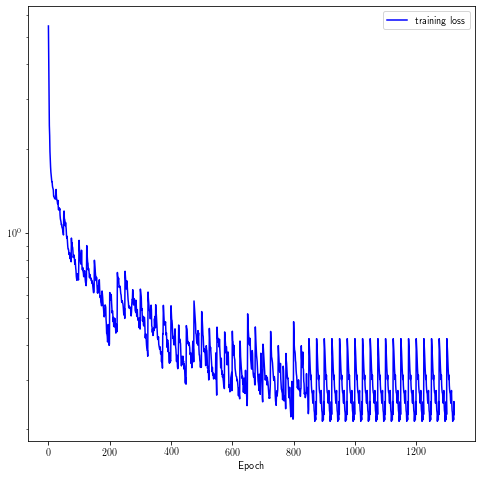

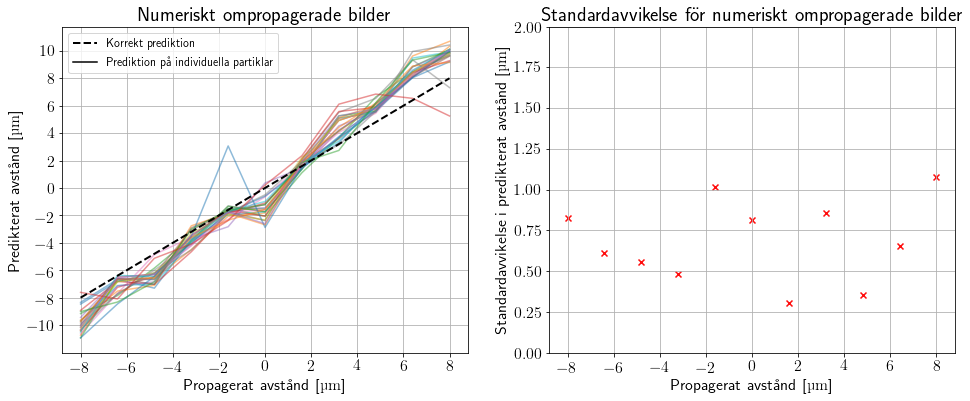

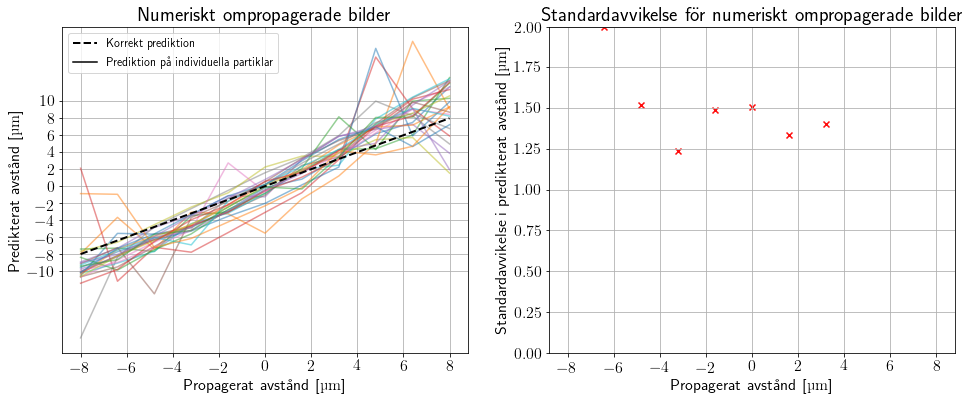

In [ ]:
save_progress(h, validation_set, val_stack, sim_val_stack, prop_range, model)